Setting Library

In [1]:
#Data Prrocessing
import pandas as pd
import datetime as dt
import numpy as np

#API
import vnstock
from vnstock import *

#Visualization
import matplotlib.pyplot as plt

#Predictions
import tensorflow as tf
tf.config.list_physical_devices('GPU') #GPU device
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Load data

In [2]:
#Company list
companies = []
fhandle = open("Data\companylist.txt","r")
order = 0
for line in fhandle.readlines():
    company = line.strip()
    order += 1
    print(f"{order}.{company}'s stock")

1.FPT's stock
2.CTG's stock
3.LCG's stock


In [3]:
company = 'FPT'
df = pd.read_csv(f"Data\Raw\{company}.csv", delimiter = ",", encoding="utf-8")
df

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate
0,0,25281.0,25365.0,24818.0,24986.0,1574450,2018-02-21
1,1,24944.0,25028.0,24481.0,24566.0,1433060,2018-02-22
2,2,24608.0,25491.0,24608.0,25449.0,1607200,2018-02-23
3,3,25659.0,25996.0,25407.0,25407.0,2467750,2018-02-26
4,4,25533.0,25575.0,25028.0,25154.0,1415610,2018-02-27
...,...,...,...,...,...,...,...
1234,1234,84200.0,84400.0,83700.0,83700.0,893299,2023-01-30
1235,1235,83500.0,83700.0,81700.0,83500.0,1531495,2023-01-31
1236,1236,84000.0,84000.0,81800.0,82000.0,1051061,2023-02-01
1237,1237,82100.0,82400.0,81300.0,81900.0,1327690,2023-02-02


Preprocessing data

In [4]:
#Format data
df['TradingDate'] = pd.to_datetime(df.TradingDate, format = "%Y/%m/%d")

In [5]:
#Candlesticks
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']

#Simple moving average
MA1 = 7
MA2 = 14
MA3 = 21
df[f'SMA_{MA1}'] = df['Close'].rolling(window = MA1).mean()
df[f'SMA_{MA2}'] = df['Close'].rolling(window = MA2).mean()
df[f'SMA_{MA3}'] = df['Close'].rolling(window = MA3).mean()

#Standard deviation
df[f'SD_{MA1}'] = df['Close'].rolling(window = MA1).std()
df[f'SD_{MA3}'] = df['Close'].rolling(window = MA3).std()

#Drop missing data
df.dropna(inplace = True)

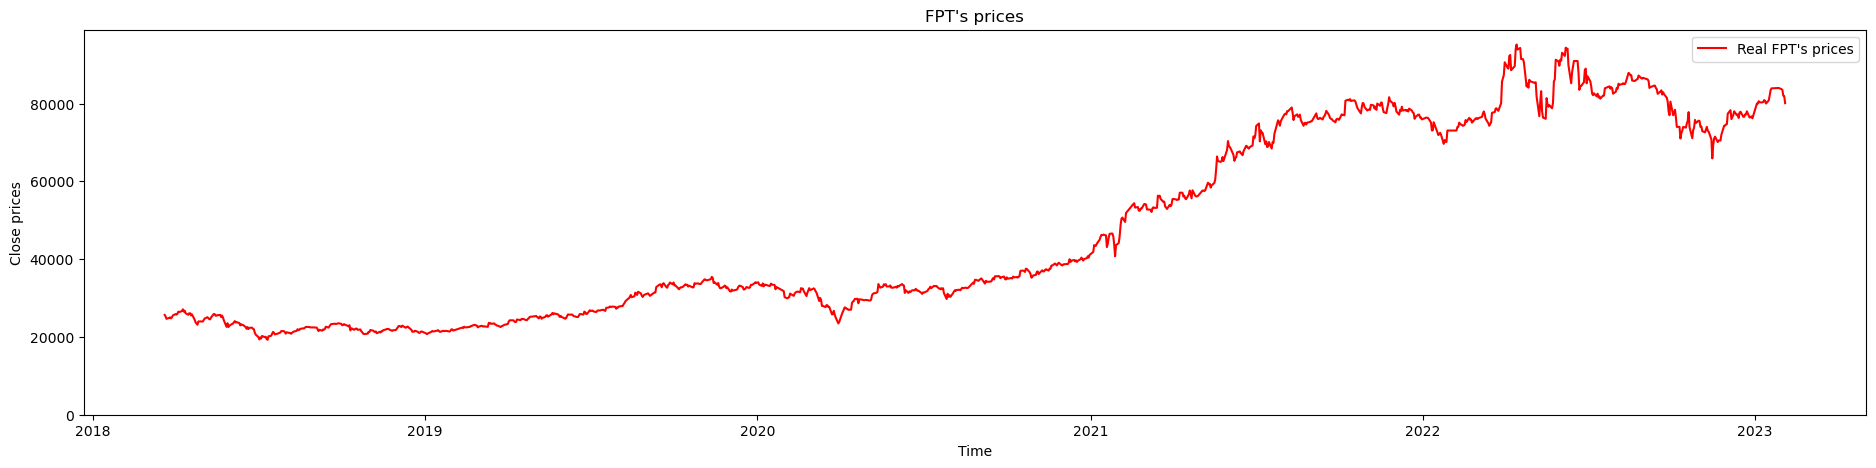

In [6]:
#Visualization
real_price = pd.DataFrame(df, columns = ['TradingDate', 'Close'])
real_price.index = real_price.TradingDate
real_price.drop('TradingDate', axis = 1, inplace = True)
plt.figure(figsize = (23,5))
plt.plot(real_price['Close'], color = "red", label = f"Real {company}'s prices")
plt.title(f"{company}'s prices")
plt.xlabel("Time")
plt.ylabel("Close prices")
plt.ylim(bottom = 0)
plt.legend() #Notices
plt.show()

In [7]:
#Exporting data
df.to_csv(f"Data\Prepaired\{company}pre.csv", encoding = "utf-8")

Processing Data

In [8]:
#Set domain
scaler_x = MinMaxScaler(feature_range = (0, 1))
scaler_y = MinMaxScaler(feature_range = (0, 1))

In [9]:
#Fit data
cols_x = ['H-L', 'O-C', f'SMA_{MA1}', f'SMA_{MA2}', f'SMA_{MA3}', f'SD_{MA1}', f'SD_{MA3}'] #Variables for training
cols_y = ['Close'] #Variable for predict
scaled_data_x = scaler_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x))) 
scaled_data_y = scaler_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

In [10]:
print(len(df))

1219


In [11]:
#Set total
pre_day = 30 #Model take 30 day and predict 1 day
x_total = [] #Variables today
y_total = [] #Close price tomorrow
for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i - pre_day:i])
    y_total.append(scaled_data_y[i])

In [12]:
#Set test
test_size = 30

#Traning set
x_train = np.array(x_total[:len(x_total)-test_size]) #tranning set
y_train = np.array(y_total[:len(y_total)-test_size]) #taget tranning set

#Predicted set
x_test = np.array(x_total[len(x_total)-test_size:]) #predicted set
y_test = np.array(y_total[len(y_total)-test_size:]) #taget predicted set

#Structure of tranning data
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1159, 30, 7) (1159, 1) (30, 30, 7) (30, 1)


Build Model

In [13]:
#Layers
model = Sequential()
dim = 300
model.add(LSTM(units = dim, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2]))) #input traning date and predicting date 
model.add(Dropout(0.2))
model.add(LSTM(units = dim, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = dim, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = dim, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = dim))
model.add(Dropout(0.2))
model.add(Dense(units = len(cols_y)))

In [ ]:
#Optimizer
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy']) #Optimizer, loss
history = model.fit(x_train, y_train, epochs = 1, batch_size = 1, use_multiprocessing = True)#Fit input to taget
len(history.history['loss'])

In [ ]:
#Save model
from keras.models import save_model

save_model(model, f"Model\{company}.h5", include_optimizer = True)

Testing

In [ ]:
#Load model
from keras.models import load_model

model = load_model(f"Model\{company}.h5")

In [ ]:
#Make predictions
predict_prices = model.predict(x_test)
predict_prices = scaler_y.inverse_transform(predict_prices)

1/1 [==============================] - 2s 2s/step


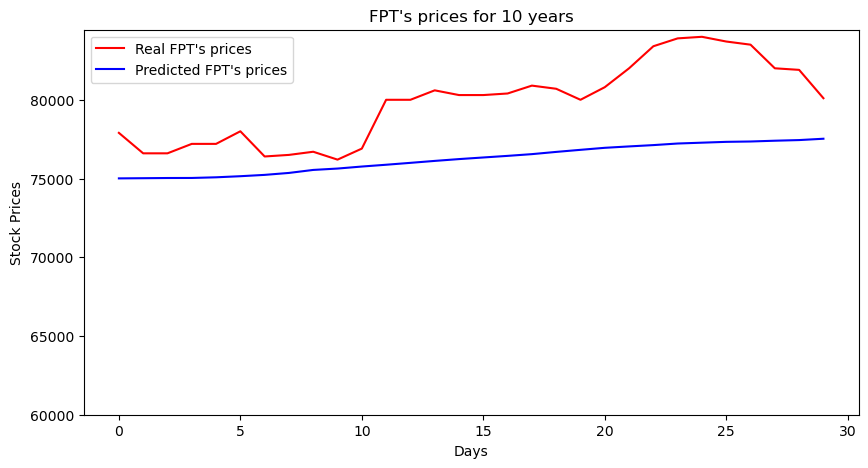

In [ ]:
#Visualization
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1, 1)
real_price = np.array(real_price)
real_price = real_price.reshape(real_price.shape[0], 1)
plt.figure(figsize = (10,5))
plt.plot(real_price, color = "red", label = f"Real {company}'s prices")
plt.plot(predict_prices, color = "blue", label = f"Predicted {company}'s prices")
plt.title(f"{company}'s prices for 10 years")
plt.xlabel("Days")
plt.ylabel("Stock Prices")
plt.ylim(bottom = 60000)
plt.legend()
plt.show()